Learn the inter-grid operator ratio for interface problems using multigrid framework,
* Dataset is constructed by changing RHS 
* Restriction and Prolongation operations are followed by a split operation
* Kernels for some part of fields are learned 

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor

import os
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import math
import random

from FEANet.mesh import MeshCircInterface
from FEANet.geo import Geometry
from FEANet.jacobi import JacobiBlock
from FEANet.model import KNet, FNet
from FEANet.multigrid import MultiGrid

from Utils import plot
from Data.dataset import RHSDataSet

In [2]:
training_set = RHSDataSet('Data/poisson2d_rhs_17x17.h5', case='train')
test_set = RHSDataSet('Data/poisson2d_rhs_17x17.h5', case='test')

train_dataloader = DataLoader(training_set, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_set, batch_size=64, shuffle=True)

In [3]:
linear_tensor_R = torch.asarray([[1, 2, 1],
                                 [2, 4, 2],
                                 [1, 2, 1]], dtype=torch.float32) / 16.0
linear_tensor_P = torch.asarray([[1, 2, 1],
                                 [2, 4, 2],
                                 [1, 2, 1]], dtype=torch.float32) / 4.0
linear_ratio = torch.asarray([4.,1.], dtype=torch.float32)

In [22]:
n = 2**4
model = MultiGrid(n, linear_tensor_R, linear_tensor_P, linear_ratio)
rhs = next(iter(train_dataloader))

0 0.1326604038476944
1 0.04196629300713539
2 0.014928971417248249
3 0.005340782459825277
4 0.0019021622138097882
5 0.0006756899529136717
6 0.0002401418169029057
7 8.536999666830525e-05
8 3.083799674641341e-05
Solution converges after 9 multi-grid iterations 


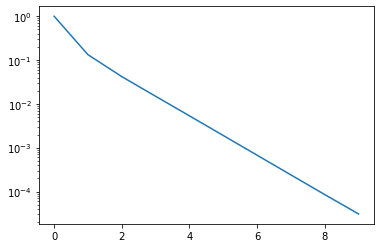

In [5]:
EPS = 5e-5
n_multigrid = 0
u = torch.zeros((1, 1, n+1, n+1), requires_grad=False, dtype=torch.float32)
res_arr = [1]
res = 1
model(rhs[1].unsqueeze(0))
err_occured = False
while (abs(res) > EPS):
    u = model.iterate(u, model.f)
    residual = model.f-model.grids[0].Knet(u)
    res_old = res
    res = torch.sqrt(torch.sum(residual[:, :, 1:-1, 1:-1] ** 2)).item()
    res_arr.append(res)
    print(n_multigrid, res)
    n_multigrid += 1

    if(res == torch.inf or math.isnan(res)):
        err_occured = True
        break

if(err_occured):
    print("The iteration doesn't converge!")
else:
    print("Solution converges after", n_multigrid, "multi-grid iterations ")
plt.plot(res_arr)
plt.yscale('log')

In [6]:
model_dir = 'Model/multigrid_rhs'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
    
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
mlist = list(model.parameters())
print('Ratio:', mlist[0][:])
print('Restriction kernel:', mlist[1][0][0])
print('Restriction kernel shape:', mlist[1].shape)
print('Interpolation kernel:', mlist[2][0][0])
print('Interpolation kernel shape:', mlist[2].shape)

Ratio: tensor([4., 1.])
Restriction kernel: tensor([[0.0625, 0.1250, 0.0625],
        [0.1250, 0.2500, 0.1250],
        [0.0625, 0.1250, 0.0625]], grad_fn=<SelectBackward0>)
Restriction kernel shape: torch.Size([1, 16, 3, 3])
Interpolation kernel: tensor([[0.2500, 0.5000, 0.2500],
        [0.5000, 1.0000, 0.5000],
        [0.2500, 0.5000, 0.2500]], grad_fn=<SelectBackward0>)
Interpolation kernel shape: torch.Size([16, 1, 3, 3])


In [7]:
def freeze_kernels(para_list, list):
    '''Freeze the kernels in list, second and third term are R and P'''
    for i in list:
        para_list[1].grad[:,i] = torch.zeros_like(para_list[1].grad[:,i])
        para_list[2].grad[i,:] = torch.zeros_like(para_list[2].grad[i,:])
        

def rewrite_kernels(para_list, list, kernels):
    '''Overwrite the kernels in list to be 'kernels', second and third term are R and P '''
    for i in list:
        para_list[1].grad[:,i] = kernels[0]
        para_list[2].grad[i,:] = kernels[1]

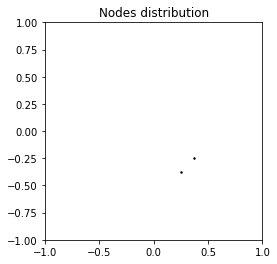

In [35]:
kernel_i = 15
mesh = MeshCircInterface(nnode_edge = n+1, outfile="Results/plate_mesh.vtk")
plot.plot_pattern(mesh, key=kernel_i)

In [9]:
freeze_list = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15] # freeze a kernel
freeze_list.remove(kernel_i)

def train_one_epoch():
    running_loss = 0.
    for i, data in enumerate(train_dataloader):
        optimizer.zero_grad() # zero the gradients for every batch
        u_out = model(data)
        loss_q = model.qm(u_out)
        
        loss_q.backward()
        para_list = list(model.parameters())
        # freeze parts of the grad to be zeros, e.g., param.grad[:,1:] = torch.zeros_like(param.grad[:,1:])
        freeze_kernels(para_list, freeze_list)
        optimizer.step()
        # overwrite the new param to be the original weight
        rewrite_kernels(para_list, freeze_list, [linear_tensor_R, linear_tensor_P])
        running_loss += loss_q.item()
    
    last_loss = running_loss/(i+1)
    return last_loss

In [10]:
num_epoch = 300
best_vloss = 1_000_000.
model_name = 'model_multigrid_interface_kernel'+str(kernel_i)

qm_train = []
for epoch in range(num_epoch):
    model.train(True)
    avg_q = train_one_epoch()
    print(epoch, avg_q)
    
    # Track best performance, and save the model's state
    mpath = os.path.join(model_dir,model_name+'.pth')
    torch.save(model.state_dict(), mpath)
    qm_train.append(avg_q)

0 0.4124090801924467
1 0.4091663081198931
2 0.41115173883736134
3 0.41129491850733757
4 0.4082997813820839
5 0.4084157273173332
6 0.4128912277519703
7 0.41430182568728924
8 0.4166264273226261
9 0.4181202668696642
10 0.4213654976338148
11 0.4213080443441868
12 0.42022303119301796
13 0.4198250863701105
14 0.419424818828702
15 0.41859192587435246
16 0.4218413569033146
17 0.4221613109111786
18 0.42282105050981045
19 0.42202272824943066
20 0.42383774369955063
21 0.4220106601715088
22 0.4245730973780155
23 0.42392262257635593
24 0.42265479266643524
25 0.426440404728055
26 0.4222059827297926
27 0.42440039850771427
28 0.4265905823558569
29 0.4239603728055954
30 0.4251532256603241
31 0.4255652166903019
32 0.4265528693795204
33 0.42599559016525745
34 0.42823530174791813
35 0.427732415497303
36 0.4294474758207798
37 0.42873576655983925
38 0.4272795394062996
39 0.43027617409825325
40 0.42990936525166035
41 0.4293745420873165
42 0.42956483736634254
43 0.42951101064682007
44 0.4285819064825773
45 0.

Text(0.5, 0, 'epoch')

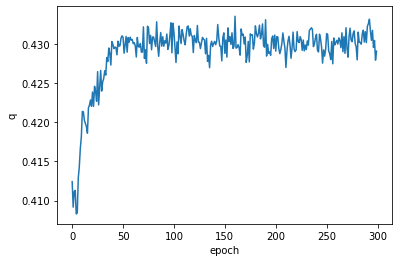

In [11]:
plt.plot(qm_train)
plt.ylabel('q')
plt.xlabel('epoch')

In [12]:
# save the list
np.save(os.path.join(model_dir,model_name+'.npy'),qm_train)

In [13]:
print('Learned parameters:')
print('Ratio:', mlist[0][:])
print('Restriction kernel:', mlist[1][0][kernel_i])
print('Interpolation kernel:', mlist[2][kernel_i][0])

print()

print('Previous parameters:')
print('Ratio:', mlist[0][:])
print('Restriction kernel:', mlist[1][0][kernel_i-1])
print('Interpolation kernel:', mlist[2][kernel_i-1][0])


Learned parameters:
Ratio: tensor([4., 1.])
Restriction kernel: tensor([[-0.0640,  0.4036,  0.0600],
        [ 0.4058, -0.0180, -0.4031],
        [ 0.0560, -0.4006,  0.4563]], grad_fn=<SelectBackward0>)
Interpolation kernel: tensor([[0.1251, 0.3368, 0.2730],
        [0.3370, 0.9780, 0.5284],
        [0.2737, 0.5284, 0.2871]], grad_fn=<SelectBackward0>)

Previous parameters:
Ratio: tensor([4., 1.])
Restriction kernel: tensor([[0.0625, 0.1250, 0.0625],
        [0.1250, 0.2500, 0.1250],
        [0.0625, 0.1250, 0.0625]], grad_fn=<SelectBackward0>)
Interpolation kernel: tensor([[0.2500, 0.5000, 0.2500],
        [0.5000, 1.0000, 0.5000],
        [0.2500, 0.5000, 0.2500]], grad_fn=<SelectBackward0>)


In [14]:
# import the learned model
model.load_state_dict(torch.load(os.path.join(model_dir,model_name+'.pth')))

<All keys matched successfully>

In [15]:
EPS = 5e-5
n_multigrid = 0
n = 2**4
u = torch.zeros((1, 1, n+1, n+1), requires_grad=False, dtype=torch.float32)
res_arr = [1]
res = 1
model(rhs[0].unsqueeze(0))
while (abs(res) > EPS):
    u = model.iterate(u, model.f)
    residual = model.f-model.grids[0].Knet(u)
    res_old = res
    res = torch.sqrt(torch.sum(residual[:, :, 1:-1, 1:-1] ** 2)).item()
    res_arr.append(res)
    print(n_multigrid, res)
    n_multigrid += 1

print("Solution converges after", n_multigrid, "multi-grid iterations ")

0 0.015273932367563248
1 0.003673573723062873
2 0.000956073694396764
3 0.0002963732404168695
4 0.00010006792581407353
5 3.877382187056355e-05
Solution converges after 6 multi-grid iterations 


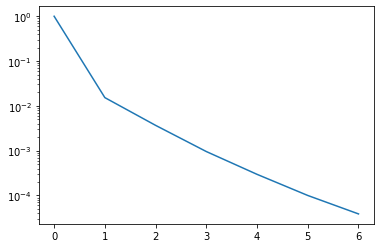

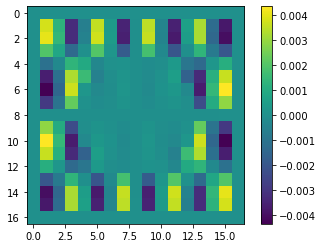

In [16]:
plt.plot(res_arr)
plt.yscale('log')
plot.plot_field(u.detach())

In [17]:
# Test the multigrid iteration
class mgTest(MultiGrid):
    '''Define the multigrid problem for 2D, n is the finest grid size'''
    def __init__(self, inter_model, n = 64):
        super(mgTest, self).__init__(n, linear_tensor_R, linear_tensor_P, linear_ratio)

        self.size = 2
        self.n = n # total number of grids for finest grid
        self.L = int(np.log2(n)) # number of levels for V-cycle multigrid
        self.x = np.linspace(-1,1,n+1, dtype=np.float32) # grid number is n+1
        self.y = np.linspace(-1,1,n+1, dtype=np.float32)
        self.xx, self.yy = np.meshgrid(self.x, self.y, indexing='xy')
        self.solution = []

        self.w = inter_model.w
        self.conv = inter_model.conv
        self.deconv = inter_model.deconv
        self.conv.requires_grad_(False)
        self.deconv.requires_grad_(False)
        self.w.requires_grad_(False)
        
        self.n_arr = self.SizeArray() # array to store grid size for each level
        self.grids = self.GridDict() # dictionary of structure grids
        
        ff = np.ones_like(self.xx)
        self.grids[0].f = self.grids[0].fnet(torch.from_numpy(ff.reshape(1,1,n+1,n+1))) # assign the finest right hand side with the original rhs
    
    def solve(self):
        '''Return error and residual array'''
        EPS = 5e-5
        n_Vcycle = 0
        self.grids[0].v = torch.zeros((1, 1, self.n+1, self.n+1), requires_grad=False, dtype=torch.float32)
        e_Vcycle, res = 1, 1
        e_arr_Vcycle = [e_Vcycle]
        res_arr_Vcycle = [res]
        err_occured = False
        while (res > EPS):
            u_prev = self.grids[0].v 
            self.grids[0].v = self.iterate(self.grids[0].v,self.grids[0].f)
            e_Vcycle = torch.sqrt(torch.sum((self.grids[0].v - u_prev) ** 2)).item() / torch.sqrt(torch.sum((self.grids[0].v) ** 2)).item()
            e_arr_Vcycle.append(e_Vcycle)
            residual = self.grids[0].f-self.grids[0].Knet(self.grids[0].v)
            res = torch.sqrt(torch.sum(residual[:, :, 1:-1, 1:-1] ** 2)).item()
            res_arr_Vcycle.append(res)
            print(e_Vcycle, res)
            n_Vcycle += 1
            if(res == torch.inf or math.isnan(res)):
                err_occured = True
                break

        if(err_occured):
            print("The iteration doesn't converge!")
        else:
            print("Solution converges after", n_Vcycle, "V-cycle iterations with relative error of", e_Vcycle)
        return e_arr_Vcycle, res_arr_Vcycle

1.0 0.2196723222732544
0.13568742016615365 0.10745691508054733
0.010800155746203239 0.04197189211845398
0.01084669423916994 0.01574108749628067
0.006434960817433404 0.006281557958573103
0.0026707032837097883 0.0027424637228250504
0.0009375146515031678 0.0012710219016298652
0.0002876110667384199 0.0006152925197966397
0.00010461017968001269 0.00030641574994660914
4.321059751473084e-05 0.00015683141828048974
2.193815018749287e-05 7.935235043987632e-05
1.2603100262115692e-05 4.2276053136447445e-05
Solution converges after 12 V-cycle iterations with relative error of 1.2603100262115692e-05


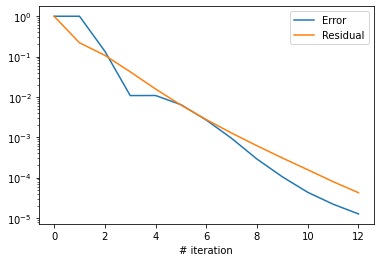

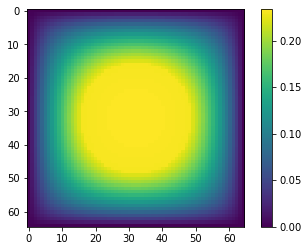

In [18]:
# Multigrid implementation
n = 2**6
prob_mg = mgTest(model, n)

e_arr_Vcycle, res_arr_Vcycle = prob_mg.solve()

plt.plot(e_arr_Vcycle, label='Error')
plt.plot(res_arr_Vcycle, label='Residual')
plt.yscale('log')
plt.xlabel('# iteration')
#plt.ylabel('Error')
plt.legend()

plot.plot_field(prob_mg.grids[0].v.detach())

In [19]:
def compute_q(res_arr):
    return np.power(res_arr[9]/res_arr[6], 1.0/4)

print("q is: ", compute_q(res_arr_Vcycle))

q is:  0.5781526868294178
